## ECON470 Homework 5-3
Author: Sarina Tan

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from linearmodels.panel import PanelOLS
import patsy
from IPython.display import Markdown, display
import pyfixest as pf
import numpy as np

# Load merged data
df = pd.read_csv('/Users/sarinatan/Desktop/HLTH470hw5/data/acs_medicaid2.txt', delimiter='\t')

## Summarize the data
### 1. Plot the share of the adult population with direct purchase health insurance over time.

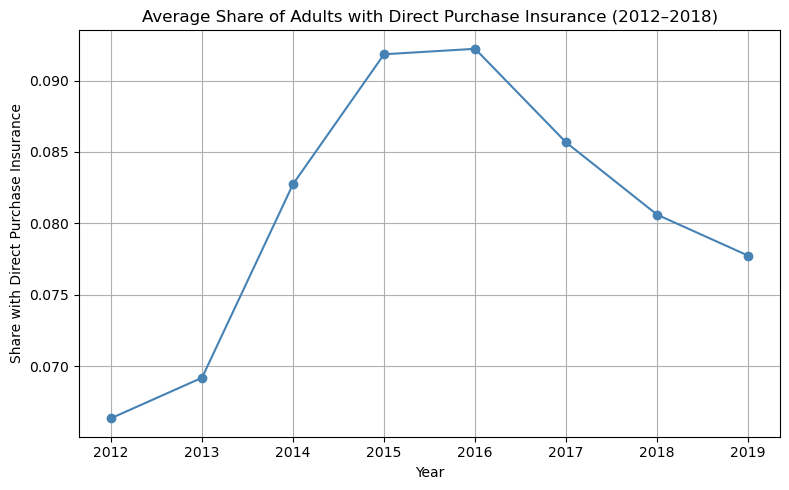

In [23]:
# Q1
# Calculate share of direct purchase insurance
df['share_direct'] = df['ins_direct'] / df['adult_pop']

# Group by year and calculate average share
trend = df.groupby('year', as_index=False)['share_direct'].mean()

# Plot
plt.figure(figsize=(8, 5))
plt.plot(trend['year'], trend['share_direct'], marker='o', linestyle='-', color='steelblue')
plt.title("Average Share of Adults with Direct Purchase Insurance (2012–2018)")
plt.xlabel("Year")
plt.ylabel("Share with Direct Purchase Insurance")
plt.grid(True)
plt.tight_layout()
plt.show()

### 2. Discuss the reduction in direct purchase health insurance in later years. Can you list a couple of policies that might have affected the success of the direct purchase insurance market?

-Repeal of the Individual Mandate Penalty (Effective 2019)

Although the mandate's repeal was passed under the Tax Cuts and Jobs Act in late 2017, its anticipated removal may have influenced consumer behavior as early as 2018. Without the financial penalty, many healthier individuals likely chose not to purchase insurance, reducing overall enrollment and contributing to higher premiums for those who remained in the market.

-Reductions in ACA Outreach and Enrollment Support

Beginning in 2017, the federal government significantly cut funding for advertising and navigator programs during the ACA’s Open Enrollment periods. This reduced public awareness and access to enrollment assistance, particularly affecting low-income individuals and those less comfortable with technology.

-Expansion of Non-ACA-Compliant Plans

In 2018, the Trump administration broadened access to short-term, limited-duration insurance plans. While these plans are more affordable, they often lack essential health benefits and consumer protections. Their availability attracted healthier individuals away from ACA-compliant plans, weakening the risk pool and further destabilizing the direct purchase market.

### 3. Plot the share of the adult population with Medicaid over time.

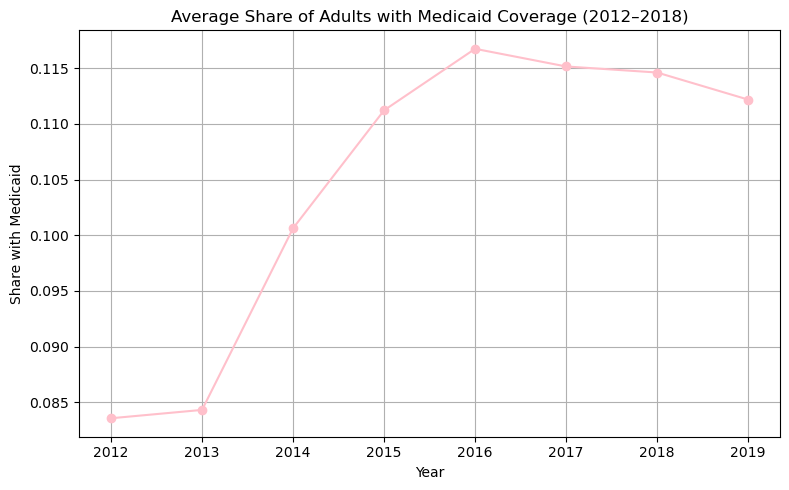

In [24]:
# Calculate share of adult population with Medicaid
df['share_medicaid'] = df['ins_medicaid'] / df['adult_pop']

# Group by year and calculate average share
medicaid_trend = df.groupby('year', as_index=False)['share_medicaid'].mean()

# Plot
plt.figure(figsize=(8, 5))
plt.plot(medicaid_trend['year'], medicaid_trend['share_medicaid'], marker='o', linestyle='-', color='pink')
plt.title("Average Share of Adults with Medicaid Coverage (2012–2018)")
plt.xlabel("Year")
plt.ylabel("Share with Medicaid")
plt.grid(True)
plt.tight_layout()
plt.show()

### 4. Plot the share of uninsured over time, separately by states that expanded Medicaid in 2014 versus those that did not. Drop all states that expanded after 2014.

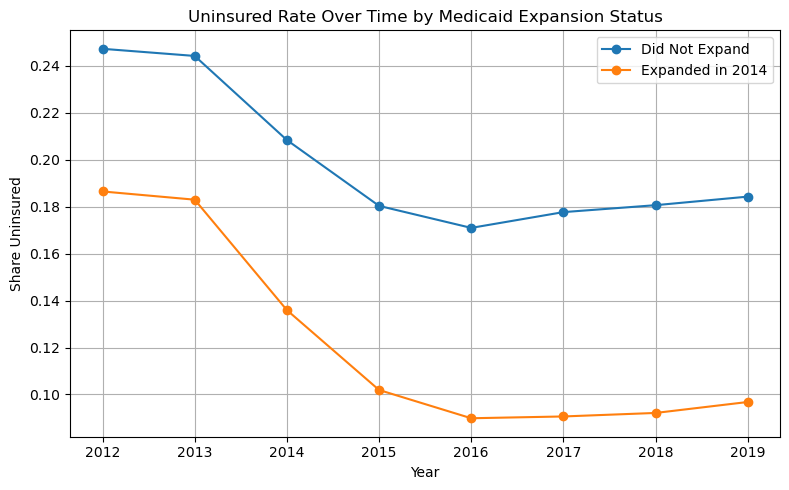

In [25]:
# Identify states that expanded in 2014 or never expanded
expansion_2014_states = df[df['expand_year'] == 2014]['State'].unique()
never_expanded_states = df[df['expand_ever'] == False]['State'].unique()

# Combine them into one list
keep_states = list(set(expansion_2014_states).union(set(never_expanded_states)))

# Filter dataset
filtered_df = df[df['State'].isin(keep_states)].copy()

# Assign group labels explicitly
filtered_df['expansion_group'] = filtered_df['State'].apply(
    lambda x: 'Expanded in 2014' if x in expansion_2014_states else 'Did Not Expand'
)

# Group by year and expansion status, then average
uninsured_trend = (
    filtered_df.groupby(['year', 'expansion_group'])['uninsured']
    .sum()
    .div(filtered_df.groupby(['year', 'expansion_group'])['adult_pop'].sum())
    .reset_index(name='share_uninsured')
)

# Plot
plt.figure(figsize=(8, 5))
for label, grp in uninsured_trend.groupby('expansion_group'):
    plt.plot(grp['year'], grp['share_uninsured'], marker='o', label=label)

plt.title("Uninsured Rate Over Time by Medicaid Expansion Status")
plt.xlabel("Year")
plt.ylabel("Share Uninsured")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Estimate ATEs
### 5. Calculate the average percent of uninsured individuals in 2012 and 2015, separately for expansion and non-expansion states. Present your results in a basic 2x2 DD table.

In [26]:
df["uninsured_rate"] = df["uninsured"] / df["adult_pop"]

# Filter for expansion in 2014 or never
reg_data = (
    df.copy()
    .loc[(df["expand_year"].isna()) | (df["expand_year"] == 2014)]
    .loc[df["year"].isin([2012, 2015])]
)

# Group and pivot the summary table
dd_table = (
    reg_data.groupby(["expand_ever", "year"])["uninsured_rate"]
    .mean()
    .reset_index()
    .pivot(index="expand_ever", columns="year", values="uninsured_rate")
    .rename(columns={2012: "Pre", 2015: "Post"})
    .reset_index()
)

# Label the groups
dd_table["Group"] = dd_table["expand_ever"].map({False: "Non-expansion", True: "Expansion"})
dd_table = dd_table[["Group", "Pre", "Post"]]

# Display markdown table
def display_markdown_table(df):
    from IPython.display import Markdown, display
    markdown = df.to_markdown(index=False)
    display(Markdown(markdown))

display_markdown_table(dd_table.round(3))

| Group         |   Pre |   Post |
|:--------------|------:|-------:|
| Non-expansion | 0.216 |  0.158 |
| Expansion     | 0.168 |  0.094 |

### 6. Estimate the effect of Medicaid expansion on the uninsurance rate using a standard DD regression estimator, again focusing only on states that expanded in 2014 versus those that never expanded.

In [27]:
reg_data = df.copy()
reg_data["post"] = (reg_data["year"] >= 2014).astype(int)
reg_data = reg_data[(reg_data["expand_year"].isna()) | (reg_data["expand_year"] == 2014)]

# Handle possible NaNs in expand_ever
reg_data = reg_data[reg_data["expand_ever"].notna()]
reg_data["expand_ever"] = reg_data["expand_ever"].astype(int)
reg_data["treat"] = reg_data["post"] * reg_data["expand_ever"]
reg_data["uninsured_rate"] = reg_data["uninsured"] / reg_data["adult_pop"]

# Step 2: Run OLS regression
model = smf.ols("uninsured_rate ~ post + expand_ever + treat", data=reg_data).fit()

# Step 3: Extract results
coefs = model.params
ses = model.bse
pvals = model.pvalues
n_obs = int(model.nobs)
r2 = model.rsquared

# Step 4: Format output table
def format_coef(val, se, p):
    stars = ""
    if p < 0.01:
        stars = "***"
    elif p < 0.05:
        stars = "**"
    elif p < 0.1:
        stars = "*"
    return f"{val:.3f}{stars} ({se:.3f})"

rows = [
    ["Post 2014", format_coef(coefs["post"], ses["post"], pvals["post"])],
    ["Expand", format_coef(coefs["expand_ever"], ses["expand_ever"], pvals["expand_ever"])],
    ["Post x Expand", format_coef(coefs["treat"], ses["treat"], pvals["treat"])],
    ["Num. Obs.", f"{n_obs}"],
    ["R2", f"{r2:.3f}"]
]

dd_table = pd.DataFrame(rows, columns=["", "Standard DD"])

print(dd_table)

                        Standard DD
0      Post 2014  -0.054*** (0.008)
1         Expand  -0.046*** (0.009)
2  Post x Expand    -0.019* (0.010)
3      Num. Obs.                352
4             R2              0.506


### 7. Include state and year fixed effects in your estimates. Try using the lfe or fixest package to estimate this instead of directly including the fixed effects.

In [28]:
# Q7: Include state and year fixed effects in your estimates.
# Step 1: Copy the same data used in Question 6
reg_data = df.copy()

# Step 2: Create post, treatment, and keep only 2014 expanders + never expanded
reg_data["post"] = (reg_data["year"] >= 2014).astype(int)
reg_data["expand_ever"] = reg_data["expand_ever"].fillna(False).astype(int)
reg_data["treat"] = reg_data["post"] * reg_data["expand_ever"]

reg_data = reg_data[(reg_data["expand_year"].isna()) | (reg_data["expand_year"] == 2014)]

# Step 3: Create your perc_unins variable
reg_data["perc_unins"] = reg_data["uninsured"] / reg_data["adult_pop"]

# Step 4: Fit models
results = []

# Standard DD (already done in Question 6, but append it if you want it again)
results.append(
    pf.feols("perc_unins ~ post + expand_ever + treat", data=reg_data)
)

# TWFE (State + Year Fixed Effects)
results.append(
    pf.feols("perc_unins ~ treat | State + year", data=reg_data)
)

# Step 5: Create results table
results_table = pf.etable(results, type="df",
                          drop="Intercept", coef_fmt="b (se)")
results_table = results_table.drop(index=["depvar", "S.E. type", "State", "year"])
results_table.columns = ["Standard DD", "TWFE"]
results_table.index = ["Post 2014", "Expand", "Post x Expand", "Num. Obs.", "R2"]
results_table = results_table.reset_index(names="")
print(results_table)

/var/folders/8z/787phzws1tj1pz4dty6ry7tm0000gn/T/ipykernel_3144/3933276809.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  reg_data["expand_ever"] = reg_data["expand_ever"].fillna(False).astype(int)


                        Standard DD              TWFE
0      Post 2014  -0.051*** (0.008)                  
1         Expand  -0.040*** (0.009)                  
2  Post x Expand    -0.022* (0.010)  -0.022** (0.008)
3      Num. Obs.                360               360
4             R2              0.469             0.947


### 8. Repeat the analysis in question 7 but include all states (even those that expanded after 2014). Are your results different? If so, why?

In [30]:
reg_data2 = df.copy()

# Step 2: Create uninsured_rate first (MUST DO THIS)
reg_data2["uninsured_rate"] = reg_data2["uninsured"] / reg_data2["adult_pop"]

# Step 3: Create time-varying treatment
reg_data2["treat"] = 0
reg_data2.loc[
    (reg_data2["year"] >= reg_data2["expand_year"]) & (reg_data2["expand_year"].notna()),
    "treat"
] = 1

# Step 4: Run regression
import pyfixest as pf  # if not already imported
results = []  # reset results if necessary
results.append(
    pf.feols("uninsured_rate ~ treat | State + year", data=reg_data2)
)

# Step 5: Create results table
results_table = pf.etable(results, type="df",
                          drop="Intercept", coef_fmt="b (se)")
results_table = results_table.drop(index=["depvar", "S.E. type", "State", "year"])
results_table.columns = ["Time-Varying Treatment"]
results_table.index = ["Treatment", "Num. Obs.", "R2"]
results_table = results_table.reset_index(names="")
# Display markdown table
def display_markdown_table(df):
    display(Markdown(df.to_markdown(index=False)))

display_markdown_table(results_table)
print (results_table)

|           | Time-Varying Treatment   |
|:----------|:-------------------------|
| Treatment | -0.024*** (0.006)        |
| Num. Obs. | 416                      |
| R2        | 0.946                    |

             Time-Varying Treatment
0  Treatment      -0.024*** (0.006)
1  Num. Obs.                    416
2         R2                  0.946


The results changed slightly in Question 8 after including all states, even those that expanded Medicaid after 2014. The ATE, which was –0.022 in Question 7, became larger in magnitude at -0.024 in Question 8. This change reflects the additional post-treatment variation introduced by later-expanding states such as Virginia and Louisiana, which transitioned from untreated to treated during the study period. By incorporating these states, the model captured more within-state changes over time, slightly strengthening the estimated effect.

### 9. Provide an “event study” graph showing the effects of Medicaid expansion in each year. Use the specification that includes state and year fixed effects, limited to states that expanded in 2014 or never expanded.



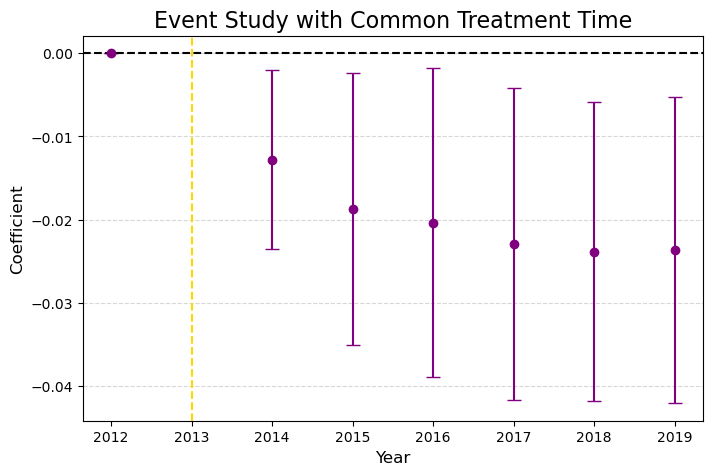

In [39]:

#QUESTION 9
# Calculate uninsured share
reg_data = df[
    (df['expand_year'].isna()) | (df['expand_year'] == 2014)
].copy()
reg_data['uninsured_share'] = reg_data['uninsured'] / reg_data['adult_pop']

# Define relative year (event time)
reg_data['relative_year'] = reg_data['year'] - reg_data['expand_year'].fillna(0)
reg_data.loc[reg_data['expand_year'].isna(), 'relative_year'] = np.inf

# Regression with event time dummies, state and year fixed effects
formula = 'uninsured_share ~ C(relative_year) + C(State) + C(year)'
model_event = smf.ols(formula, data=reg_data).fit(
    cov_type='cluster', cov_kwds={'groups': reg_data['State']}
)

# Extract event-time coefficients (exclude inf and base year -1)
event_years = sorted(set(reg_data['relative_year']) - {np.inf, -1})
calendar_years = [2014 + yr for yr in event_years]

coefs = []
conf_lowers = []
conf_uppers = []

for yr in event_years:
    label = f'C(relative_year)[T.{yr}]'
    coef = model_event.params.get(label, 0)
    ci = model_event.conf_int().loc[label] if label in model_event.params else [0, 0]
    coefs.append(coef)
    conf_lowers.append(ci[0])
    conf_uppers.append(ci[1])

# Plot
plt.figure(figsize=(8, 5))
plt.errorbar(calendar_years, coefs,
             yerr=[np.array(coefs) - np.array(conf_lowers), np.array(conf_uppers) - np.array(coefs)],
             fmt='o', color='purple', capsize=5)
plt.axhline(0, color='black', linestyle='--')
plt.axvline(2013, color='gold', linestyle='--')
plt.xticks(range(2012, 2020))  # Ensure all years from 2012 to 2019 show
plt.title('Event Study with Common Treatment Time', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Coefficient', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


### 10. Repeat part 9 but again include states that expanded after 2014. Note: this is tricky…you need to put all states onto “event time” to create this graph.

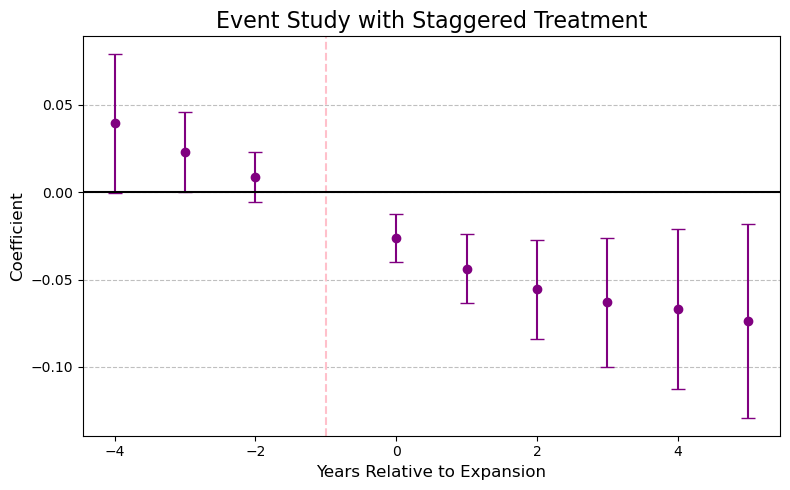

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# Step 1: Create relative year (event time)
reg_data2 = df.copy()
reg_data2["relative_year"] = (reg_data2["year"] - reg_data2["expand_year"]).fillna(np.inf)
reg_data2 = reg_data2[reg_data2["relative_year"] != np.inf]  # Keep only states with expansion year
reg_data2["relative_year"] = reg_data2["relative_year"].clip(lower=-4, upper=5)
reg_data2["uninsured_rate"] = reg_data2["uninsured"] / reg_data2["adult_pop"]

# Step 2: Create event dummies
for yr in range(-4, 6):  # -4 to 5
    if yr == -1:
        continue  # reference category
    colname = f"event_m{abs(yr)}" if yr < 0 else f"event_p{yr}"
    reg_data2[colname] = (reg_data2["relative_year"] == yr).astype(int)

# Step 3: Run regression (with State + year FE)
event_vars = [f"event_m{abs(i)}" if i < 0 else f"event_p{i}" for i in range(-4, 6) if i != -1]
formula = f"uninsured_rate ~ {' + '.join(event_vars)} + C(State) + C(year)"
event_model = smf.ols(formula=formula, data=reg_data2).fit()

# Step 4: Extract coefficients and SEs
coefs = event_model.params[event_vars]
errors = event_model.bse[event_vars]

# Step 5: Convert names to relative years for x-axis
event_years = [-int(var.replace('event_m', '')) if 'event_m' in var else int(var.replace('event_p', '')) for var in event_vars]

# Step 6: Plot
plt.figure(figsize=(8, 5))
plt.errorbar(event_years, coefs, yerr=1.96 * errors, fmt='o', color='purple', capsize=5)
plt.axvline(x=-1, color="pink", linestyle="--")
plt.axhline(y=0, color="black", linestyle="-")
plt.title("Event Study with Staggered Treatment", fontsize=16)
plt.ylabel("Coefficient", fontsize=12)
plt.xlabel("Years Relative to Expansion", fontsize=12)
plt.grid(axis='y', color='gray', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()